Start by loading some of the usual libraries.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

Load the data using Pandas.

In [2]:
df_sign = pd.read_csv("../Dataset/signup_data.csv",sep='\t',header=0)
df_sear = pd.read_csv("../Dataset/search_data.csv",sep='\t',header=0)
df_call = pd.read_csv("../Dataset/call_data.csv",sep='\t',header=0)
df_mess = pd.read_csv("../Dataset/message_data.csv",sep='\t',header=0)

Let's look at the basic data format and stats (counts, min/max etc.)

In [3]:
def quick_look(df):
    print(df.head())
    print(df.describe())
    print('----------')

quick_look(df_sign)
quick_look(df_sear)
quick_look(df_call)
quick_look(df_mess)

    user_id country_code      signup_ts
0  10000000           IT  1552867200000
1  10000001           IT  1551571200000
2  10000002           SE  1554163200000
3  10000003           IT  1553644800000
4  10000004           IT  1554076800000
            user_id     signup_ts
count  2.600000e+04  2.600000e+04
mean   1.001300e+07  1.552914e+12
std    7.505698e+03  7.711053e+08
min    1.000000e+07  1.551485e+12
25%    1.000650e+07  1.552262e+12
50%    1.001300e+07  1.552954e+12
75%    1.001950e+07  1.553558e+12
max    1.002600e+07  1.554163e+12
----------
    user_id      search_ts
0  10001110  1554188089059
1  10001010  1553159392120
2  10018492  1554296508598
3  10008817  1553186210012
4  10015005  1554189287541
            user_id     search_ts
count  8.671310e+05  8.671310e+05
mean   1.001302e+07  1.553194e+12
std    7.510615e+03  7.663035e+08
min    1.000000e+07  1.551485e+12
25%    1.000644e+07  1.552577e+12
50%    1.001320e+07  1.553278e+12
75%    1.001945e+07  1.553854e+12
max    1.

Some key take aways:
25,000 users signed up for Truecaller.
They performed 842,131 searches, whatever those are.
They took part in 1,222,833 calls and only 105,279 SMS.
All of this took place after timestamp ~1.551485e+12 and before ~1.554336e+12.
All csv files have identical formatting: user_id & timestamp of action, except the singup table also has country code.

The timestamps look like Unix timestamps.  Let's see:

In [4]:
from datetime import date
#date.fromtimestamp(1554229361941)  # Throws error!  ValueError: year 51221 is out of range

No, so the timestamps are much too large to be Unix time.  But they look similar to the current Unix time * 1000.  Let's try:

In [197]:
date.fromtimestamp(1554229361.941)

2

In [6]:
print("first signup: ", date.fromtimestamp(df_sign[df_sign.columns[-1]].min()/1000))
print("last  signup: ", date.fromtimestamp(df_sign[df_sign.columns[-1]].max()/1000))

first signup:  2019-03-02
last  signup:  2019-04-02


Okay, so one month of data, quite recent.  Let's take a closer look at the timestamps with some histograms.

signups:


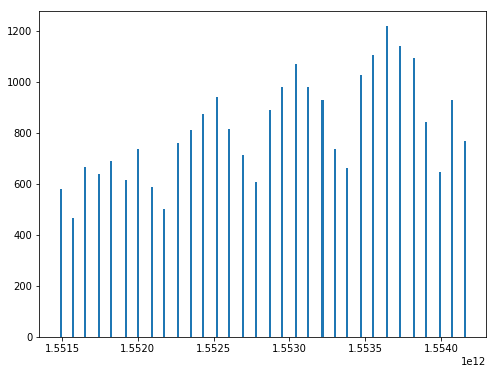

searches:


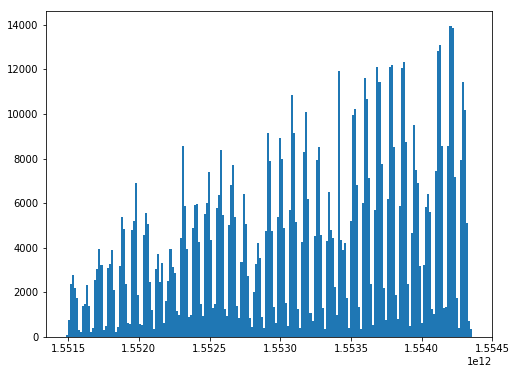

calls:


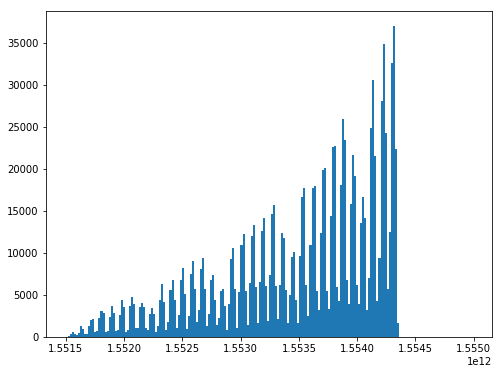

SMS:


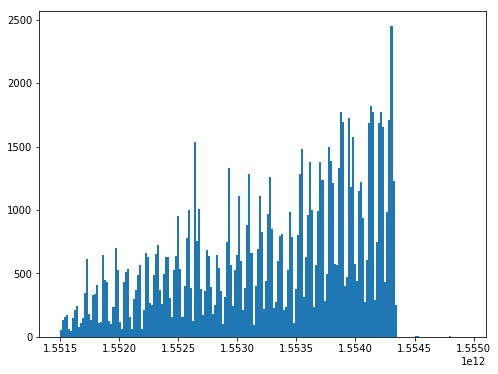

In [82]:
def quick_plot(df):
    ts_col = df.columns[-1] # Last column is always the timestamp
    plt.figure(figsize=(8,6))
    plt.hist(df[ts_col],bins=200)
    plt.show()
    
print("signups:")
quick_plot(df_sign)
print("searches:")
quick_plot(df_sear)
print("calls:")
quick_plot(df_call)
print("SMS:")
quick_plot(df_mess)

In [83]:
def distinct_comparison(df):
    print(df.columns)
    print(len(df['user_id']))
    print(len(df['user_id'].unique()))
    print('----------')
    
distinct_comparison(df_sign)
distinct_comparison(df_sear)
distinct_comparison(df_call)
distinct_comparison(df_mess)

Index(['user_id', 'country_code', 'signup_ts'], dtype='object')
26000
26000
----------
Index(['user_id', 'search_ts'], dtype='object')
867131
26000
----------
Index(['user_id', 'call_ts'], dtype='object')
1223795
24439
----------
Index(['user_id', 'message_ts'], dtype='object')
105785
8452
----------


All user_ids participate in at least one search, ~33.6 searches on average.  Almost all user_ids make a call, but 1050 user_ids don't.  Perhaps they only send SMS.  That's an average of 51 calls/active user or 49 including the non-callers.  Only ~33% of user_ids send SMS.  Active SMS senders sent ~13 SMS.  ~4 SMS / user including the non-senders. 

Calls + SMS = 1328112, which is much higher than the number of searches, so some calls/SMS must not trigger a search.

The search_ts plots show some suspicious spike, but let's proceed by aggregating actions taken by each user_id to get a high level summary of their activity.

In [84]:
df_sign_agg = df_sign # No agg required
df_sear_agg = df_sear.groupby(['user_id']).count()
df_call_agg = df_call.groupby(['user_id']).count()
df_mess_agg = df_mess.groupby(['user_id']).count()

In [85]:
df_join = df_sign_agg.join(df_sear_agg, on='user_id')
df_join = df_join.join(df_call_agg, on='user_id')
df_join = df_join.join(df_mess_agg, on='user_id')

In [86]:
# Set NaNs/NULLs to 0
df_join.fillna(value=0,inplace=True)

In [87]:
quick_look(df_join)

    user_id country_code      signup_ts  search_ts  call_ts  message_ts
0  10000000           IT  1552867200000         16     36.0         1.0
1  10000001           IT  1551571200000         20     64.0         0.0
2  10000002           SE  1554163200000         17      5.0         2.0
3  10000003           IT  1553644800000         38     60.0         0.0
4  10000004           IT  1554076800000         37     24.0         0.0
            user_id     signup_ts     search_ts       call_ts    message_ts
count  2.600000e+04  2.600000e+04  26000.000000  26000.000000  26000.000000
mean   1.001300e+07  1.552942e+12     33.351192     47.069038      4.068654
std    7.505698e+03  7.645713e+08     63.690141     57.287840     29.063801
min    1.000000e+07  1.551485e+12      1.000000      0.000000      0.000000
25%    1.000650e+07  1.552349e+12     19.000000     15.000000      0.000000
50%    1.001300e+07  1.553040e+12     28.000000     30.000000      0.000000
75%    1.001950e+07  1.553645e+12   

In [88]:
#plt.matshow(df_join.corr())
corr = df_join.corr()
print(df_join.columns)
corr.style.background_gradient()

Index(['user_id', 'country_code', 'signup_ts', 'search_ts', 'call_ts',
       'message_ts'],
      dtype='object')


,user_id,signup_ts,search_ts,call_ts,message_ts
user_id,1,-0.000668728,0.00118991,-0.0106869,0.00238936
signup_ts,-0.000668728,1,-0.0586474,-0.112064,-0.0374762
search_ts,0.00118991,-0.0586474,1,-0.0391347,-0.0126129
call_ts,-0.0106869,-0.112064,-0.0391347,1,-0.00471545
message_ts,0.00238936,-0.0374762,-0.0126129,-0.00471545,1


There's very little correlation between the counts of searches, calls, and SMS.  Strange.  Some correlation between country and calling patterns, may be a lead.  User_ids correlate almost perfectly with signup timestamps, but this is trivially true if user_ids are assigned as new users join.  Not a hint.

In [89]:
from sklearn.manifold import TSNE
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_join['country_code'])
df_join['country_code'] = le.transform(df_join['country_code'])

#X_embedded = TSNE(n_components=2).fit_transform(df_join.values)

In [90]:
le.transform(['GB','FR'])

array([2, 1])

In [91]:
df_join.iloc[:,1:].shape

(26000, 5)

In [26]:
X_embedded = TSNE(n_components=2).fit_transform(df_join.iloc[:,1:]) # Drop out user_ids

In [27]:
X_embedded.shape

(25000, 2)

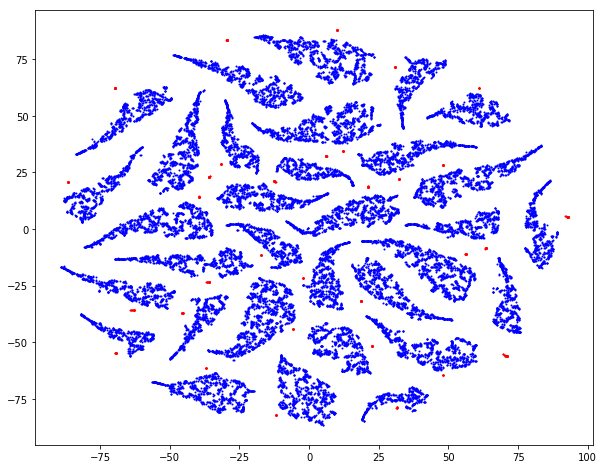

In [60]:
# T-SNE is a form of dimensionality reduction that maps, in this case, a 
plt.figure(figsize=(10,8))
plt.scatter(X_embedded[:,0],X_embedded[:,1],s=1,c='r')
#plt.scatter(X_embedded[df_join['fraud']==True][:,0],X_embedded[df_join['fraud']==True][:,1],s=1,c='r')
#plt.scatter(X_embedded[df_join['fraud']!=True][:,0],X_embedded[df_join['fraud']!=True][:,1],s=1,c='b')
plt.show()

Well, that's goofy looking.  Sadly, there are not a few simple distinct clusters that would indicate a set of fraudulent users that stand out against normal users.  Bummer.  Rather than aggregate over all times, let's try to use timing information.  

signup_ts


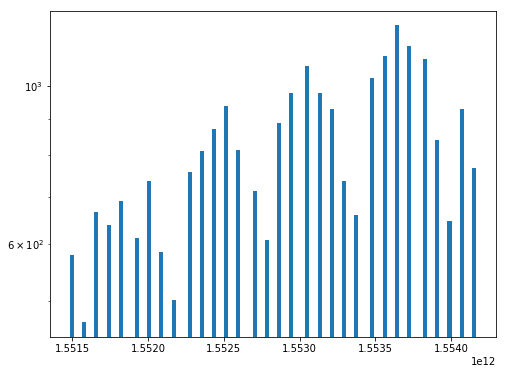

search_ts


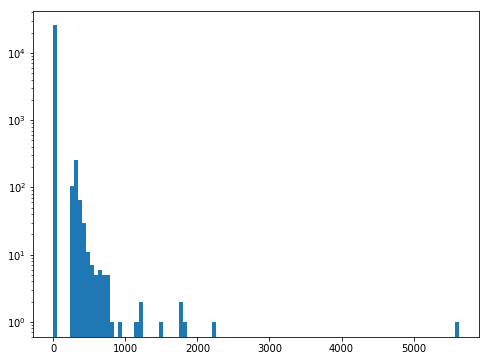

call_ts


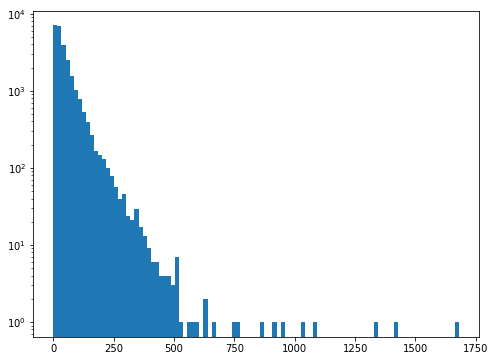

message_ts


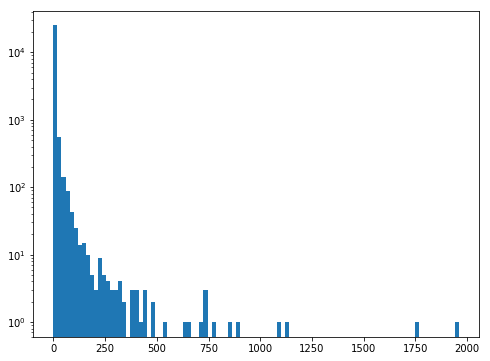

In [347]:
def quick_plot(col_name):
    print(col_name)
    m,s = np.mean(df_join[col_name]),np.std(df_join[col_name])
    plt.figure(figsize=(8,6))
    plt.yscale('log')
    #nbins = 100
    plt.hist(df_join[col_name],bins=100)
    #plt.hist(np.clip(df_join[col_name],0,100),bins=100)
    #plt.axvline(x=m+3*s,c='red')
    plt.show()

quick_plot('signup_ts')
quick_plot('search_ts')
quick_plot('call_ts')
quick_plot('message_ts')


The searches seem to have a bulk of regular users with <=50 searches and a bump of ~500 users who make >=100 searches.  Let's look at calling/SMS behavior in comparison.  Also, there's a big spike in the number of users making 30 searches/day.  Should be investigated.

The users making >=100 searches make suspiciously few calls+texts.  It looks like they are manually triggering many caller ID searches without normal call/text usage.  These could be scrapers.  We can label them as fraud with the following:

In [94]:
df_join['fraud'] = df_join['search_ts']>100

Let's break things down by country to look for patterns:

signup_ts


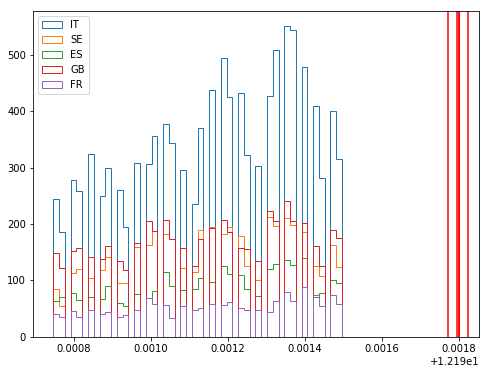

search_ts


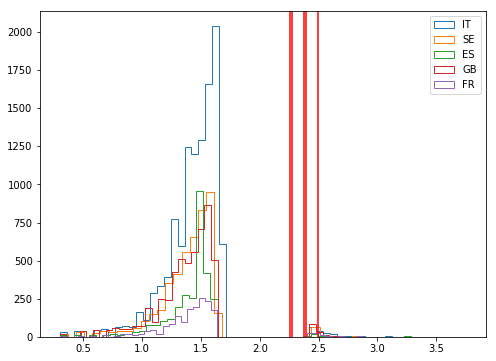

call_ts


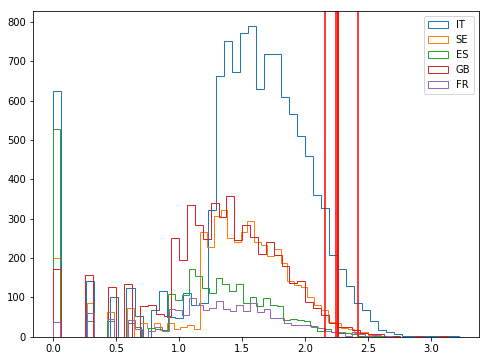

message_ts


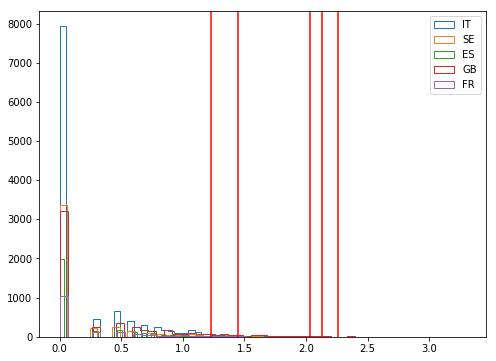

In [101]:
def quick_plot_agg_by_country(col_name):
    print(col_name)
    plt.figure(figsize=(8,6))
    for country in pd.unique(df_join['country_code']):
        #plt.yscale('log')
        #plt.xscale('log')
        nbins = 50
        cut = df_join['country_code']==country
        m,s = np.mean(df_join[cut][col_name]),np.std(df_join[cut][col_name])
        plt.hist(np.log10(df_join[cut][col_name]+1),bins=nbins,histtype='step',label=le.inverse_transform([country]))
        plt.axvline(x=np.log10(m+3*s),c='red')
    plt.legend()
    plt.show()
    
quick_plot_agg_by_country('signup_ts')
quick_plot_agg_by_country('search_ts')
quick_plot_agg_by_country('call_ts')
quick_plot_agg_by_country('message_ts')


Spain (ES) has a big spike at 30.  Italy (IT) has a bump as well.  

In [108]:
cut = (df_join['search_ts']==30) & (df_join['call_ts']+df_join['message_ts']<=3) & (df_join['country_code']==0)
df_join[cut]

,user_id,country_code,signup_ts,search_ts,call_ts,message_ts,fraud
39,10000039,0,1553904000000,30,0.0,0.0,False
92,10000092,0,1551916800000,30,0.0,0.0,False
133,10000133,0,1552694400000,30,0.0,0.0,False
158,10000158,0,1552176000000,30,0.0,0.0,False
260,10000260,0,1552089600000,30,0.0,0.0,False
406,10000406,0,1551744000000,30,0.0,0.0,False
652,10000652,0,1553817600000,30,0.0,0.0,False
713,10000713,0,1553212800000,30,0.0,0.0,False
737,10000737,0,1552089600000,30,0.0,0.0,False
745,10000745,0,1553040000000,30,0.0,0.0,False


So there's a big collection of 500 user_ids who make exactly 30 searches with 0 calls or SMS.  Let's label them as fraud2.  They look like bots.  

In [109]:
df_join['fraud2'] = (df_join['search_ts']==30) & (df_join['call_ts']+df_join['message_ts']<=3) & (df_join['country_code']==0)

In [112]:
len(df_join[df_join['fraud2']==True])

500

Let's try looking at timing information.  Country may be important like in the group above, so let's make timing plots with country information. 

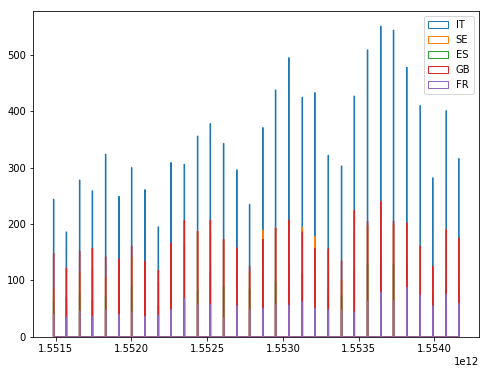

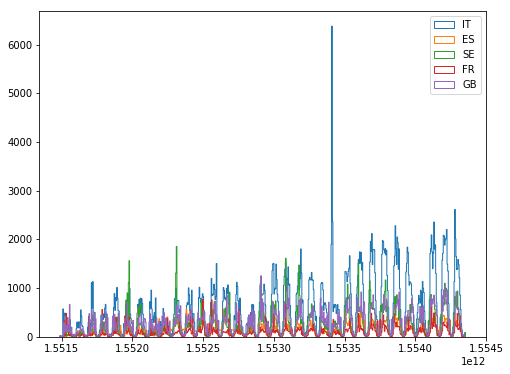

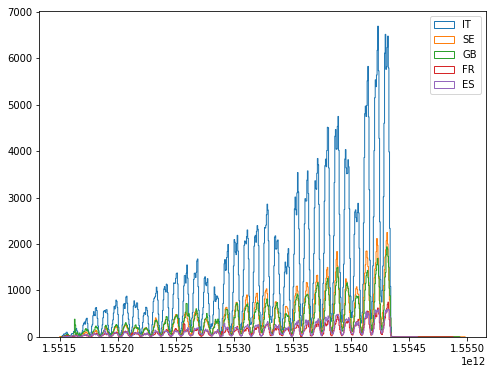

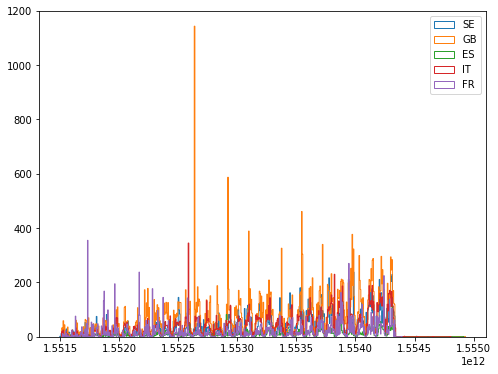

In [152]:
def quick_plot_time_by_country(df):
    col_name = df.columns[-1]
    if 'country_code' not in df.columns:
        df = df.set_index('user_id').join(df_sign.set_index('user_id'), on='user_id')
    plt.figure(figsize=(8,6))
    for country in pd.unique(df['country_code']):
        #plt.yscale('log')
        #plt.xscale('log')
        nbins = 640
        cut = df['country_code']==country
        #m,s = np.mean(df[cut][col_name]),np.std(df[cut][col_name])
        plt.hist(df[cut][col_name],bins=nbins,histtype='step',label=[country])
        #plt.axvline(x=np.log10(m+3*s),c='red')
    plt.legend()
    plt.show()
    
quick_plot_time_by_country(df_sign)
quick_plot_time_by_country(df_sear)
quick_plot_time_by_country(df_call)
quick_plot_time_by_country(df_mess)

Whoa, there's a huge spike in searches from Italy in one timestamp.  There's also a big spike in SMS from GB... Might be worth investigating.  Let's start with merging search data timestamps with geo.  

In [134]:
df_sear_cc = df_sear.join(df_sign.set_index('user_id'), on='user_id') 

,user_id,search_ts,country_code,signup_ts
0,10001110,1554188089059,IT,1553817600000
1,10001010,1553159392120,ES,1553126400000
2,10018492,1554296508598,SE,1552953600000
3,10008817,1553186210012,IT,1553126400000
4,10015005,1554189287541,FR,1554163200000


In [164]:
cut = (df_sear_cc['country_code']=='IT') & (df_sear_cc['signup_ts']>np.mean(df_sear_cc['signup_ts']))
hist = np.histogram(df_sear_cc[cut]['search_ts'],bins=32)

In [238]:
date.fromtimestamp(1553844208.4762188).day

29

In [292]:
from datetime import timedelta
start_ts = np.min(df_test['signup_ts'])


In [200]:
df_test['day'] = [date.fromtimestamp(ts).day for ts in df_test['signup_ts']/1000.]

In [295]:
start_ts

1551484800000

In [302]:
df_test['min'] = (df_test['search_ts']-start_ts)/1000./60

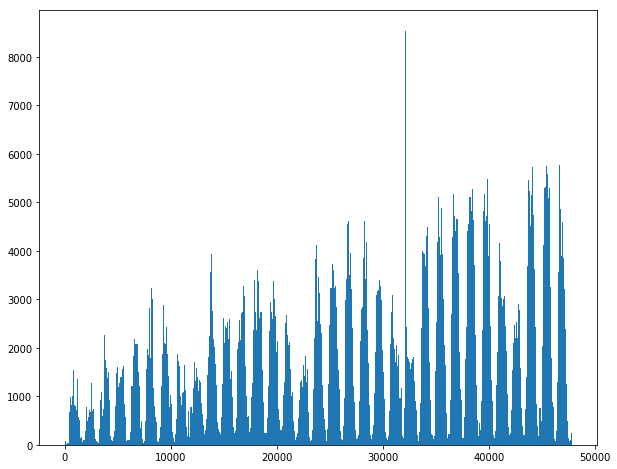

In [349]:
plt.figure(figsize=(10,8))
cut = (df_test['country_code']=='IT')
plt.hist(df_test['min'],bins=500)
plt.show()

Zoom in on the big spike.

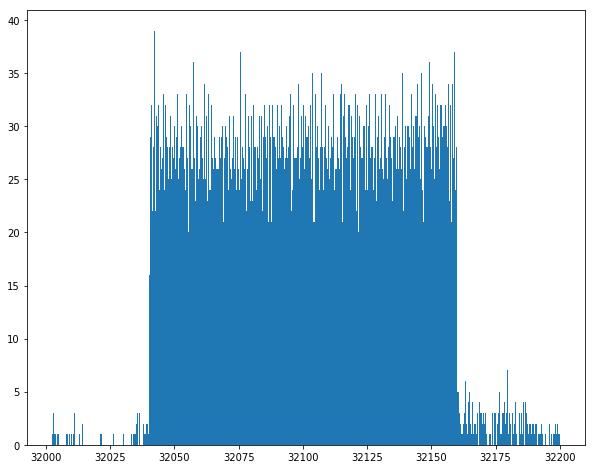

In [306]:
plt.figure(figsize=(10,8))
cut = (df_test['country_code']=='IT') & (df_test['min']>32000) & (df_test['min']<32200)
#plt.xlim([1553844208476-6*24*60*60*1000,1553844208476-3*24*60*60*1000])
plt.hist(df_test[cut]['min'],bins=600)
plt.show()

So there's some very suspicous activity between delta-minutes 32030 and 32165.  

In [312]:
cut = (df_test['min']>32030) & (df_test['min']<=32165) & (df_test['country_code']=='IT')
df_suspect = df_test[cut].groupby(df_test['user_id']).count()
cut = (df_test['min']<=32030) | (df_test['min']>32165)
df_clear   = df_test[cut].groupby(df_test['user_id']).count()

In [313]:
fraud3 = np.setdiff1d(df_suspect.index.values,df_clear.index.values)

We found three different fraudulent behaviors in fraud groups 1,2,3.  Let's concatentate them and wrap up.

In [324]:
fraud1 = df_join[df_join['fraud']==True]['user_id'].values
len(fraud1)

500

In [325]:
fraud2 = df_join[df_join['fraud2']==True]['user_id'].values
len(fraud2)

500

In [314]:
len(fraud3)

500

In [339]:
fraud_user_ids = np.concatenate([fraud1,fraud2,fraud3])

In [340]:
len(fraud_user_ids)

1500

In [344]:
df_fraud = pd.DataFrame(fraud_user_ids,columns=['user_id'])
df_fraud.head()

,user_id
0,10000031
1,10000082
2,10000087
3,10000108
4,10000115


In [358]:
df_fraud.to_csv('Results.csv',index=False)